In [29]:
from prophet import Prophet
import pandas as pd
import pandas_gbq

from datetime import date

In [4]:
project_id = 'ferrous-weaver-306014'

In [45]:
query = """
select
    date(date(creation_datetime)) as ds,
    count(distinct ID) as y
from
    `clinical_reporting_pipeline.inbound_referrals`
where
    client is not null
    and ID is not null
    and client = 'Conviva'
    and date(creation_datetime) >= '2025-04-01'
group by all
order by
    DS desc
"""

In [47]:
df = pandas_gbq.read_gbq(query, project_id=project_id)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [48]:
df.head()

,ds,y
0,2025-06-10,8
1,2025-06-09,9
2,2025-06-06,10
3,2025-06-05,6
4,2025-06-04,6


In [49]:
m = Prophet()
m.fit(df)

00:04:19 - cmdstanpy - INFO - Chain [1] start processing
00:04:19 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
future = m.make_future_dataframe(periods=252)
future.tail()

,ds
298,2026-02-13
299,2026-02-14
300,2026-02-15
301,2026-02-16
302,2026-02-17


In [51]:
forecast = m.predict(future)

In [52]:
forecast["run_date"] = pd.to_datetime(date.today())

In [53]:
df_out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','run_date']]
df_out.head()

,ds,yhat,yhat_lower,yhat_upper,run_date
0,2025-04-01,10.937685,5.913010,15.513498,2025-06-12
1,2025-04-02,15.204840,10.452808,19.968897,2025-06-12
2,2025-04-03,10.907421,6.020249,15.766970,2025-06-12
3,2025-04-04,10.907466,6.234168,15.651006,2025-06-12
4,2025-04-07,11.322776,6.627831,16.234963,2025-06-12


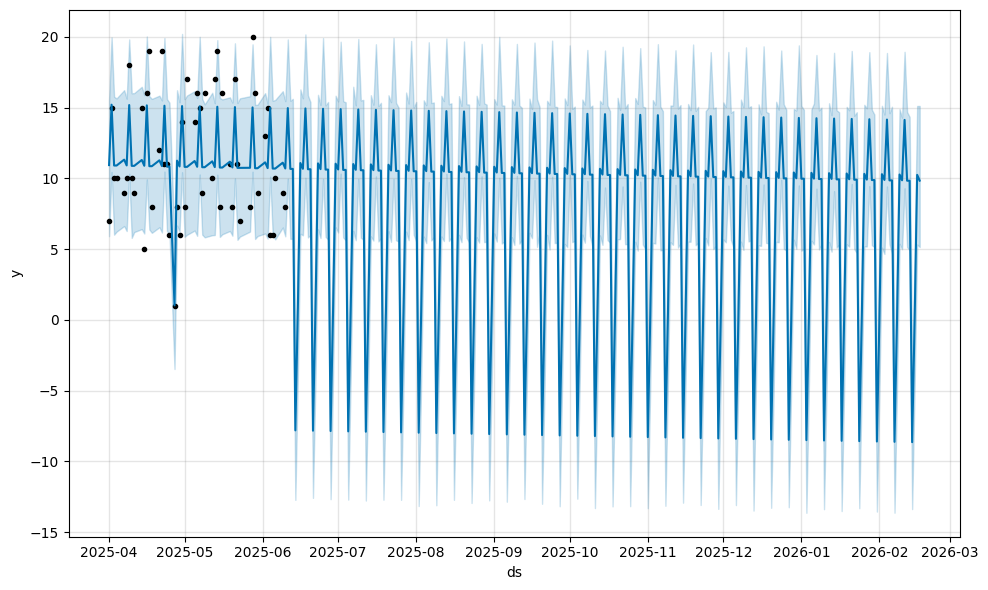

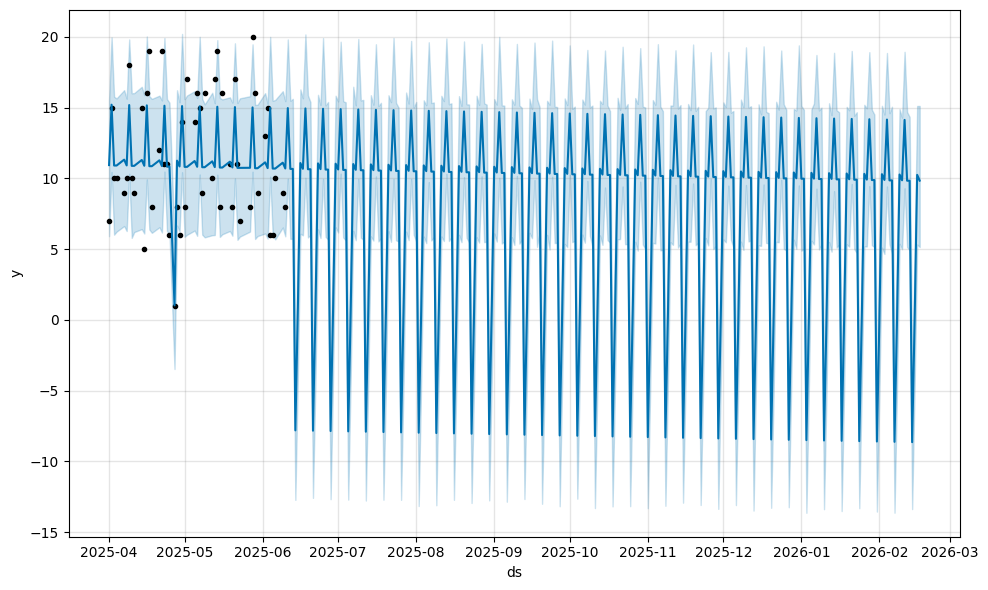

In [54]:
fig2 = m.plot(forecast)
fig2

In [55]:
pandas_gbq.to_gbq(
    df_out, 
    destination_table="capacity_plan.prophet_run",
    project_id=project_id,
    if_exists="replace"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]
